# Detecting Gaze in using the "Eye Tracking for Everyone" Neural Network

This will go through the process of extracting the features from an image that are needed for the neural network, testing the input, and displaying the output.

## Extracting the Inputs from an Image using OpenCV

The neural network requires as inputs:
* an image of the left eye, (224x224)
* an image of the right eye (224x224)
* an image of the fafce (224x224)
* a 625 array representing where in a 25x25 grid the face is

Here we will use OpenCV to extract this from a single image.  Much of this code is based on the instruction at 
https://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html

In [31]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
# filter out the warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
cascades_path = '/usr/share/opencv/haarcascades/'
face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_eye.xml')

In [33]:
import time

def current_time():
    return int(round(time.time() * 1000))

def extract_face_features(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]
    face_image = np.copy(img[y:y+h, x:x+w])
    
    eyes = eye_cascade.detectMultiScale(roi_gray)
    eye_images = []
    for (ex,ey,ew,eh) in eyes:
        eye_images.append(np.copy(img[y+ey:y+ey+eh,x+ex:x+ex+ew]))
                
    roi_color = img[y:y+h, x:x+w]
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
    
    return face_image, eye_images

def get_face_grid(face, frameW, frameH, gridSize):
    faceX,faceY,faceW,faceH = face

    return faceGridFromFaceRect(frameW, frameH, gridSize, gridSize, faceX, faceY, faceW, faceH, False)

def extract_image_features(full_img_path):
    img = cv2.imread(full_img_path)
    start_ms = current_time()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    faces = []
    face_features = []
    for [x,y,w,h] in face_detections:
        face = [x, y, w, h]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        face_image, eye_images = extract_face_features(face, img, gray)
        face_grid = get_face_grid(face, img.shape[1], img.shape[0], 25)
        
        faces.append(face)
        face_features.append([face_image, eye_images, face_grid])
    
    duration_ms = current_time() - start_ms
    print("Face and eye extraction took: ", str(duration_ms / 1000) + "s")
    
    return img, faces, face_features

gridSize = 25

In [34]:
# This code is converted from https://github.com/CSAILVision/GazeCapture/blob/master/code/faceGridFromFaceRect.m

# Given face detection data, generate face grid data.
#
# Input Parameters:
# - frameW/H: The frame in which the detections exist
# - gridW/H: The size of the grid (typically same aspect ratio as the
#     frame, but much smaller)
# - labelFaceX/Y/W/H: The face detection (x and y are 0-based image
#     coordinates)
# - parameterized: Whether to actually output the grid or just the
#     [x y w h] of the 1s square within the gridW x gridH grid.

def faceGridFromFaceRect(frameW, frameH, gridW, gridH, labelFaceX, labelFaceY, labelFaceW, labelFaceH, parameterized):

    scaleX = gridW / frameW
    scaleY = gridH / frameH
    
    if parameterized:
      labelFaceGrid = np.zeros(4)
    else:
      labelFaceGrid = np.zeros(gridW * gridH)
    
    grid = np.zeros((gridH, gridW))

    # Use one-based image coordinates.
    xLo = round(labelFaceX * scaleX)
    yLo = round(labelFaceY * scaleY)
    w = round(labelFaceW * scaleX)
    h = round(labelFaceH * scaleY)

    if parameterized:
        labelFaceGrid = [xLo, yLo, w, h]
    else:
        xHi = xLo + w
        yHi = yLo + h

        # Clamp the values in the range.
        xLo = int(min(gridW, max(0, xLo)))
        xHi = int(min(gridW, max(0, xHi)))
        yLo = int(min(gridH, max(0, yLo)))
        yHi = int(min(gridH, max(0, yHi)))

        faceLocation = np.ones((yHi - yLo, xHi - xLo))
        grid[yLo:yHi, xLo:xHi] = faceLocation

        # Flatten the grid.
        grid = np.transpose(grid)
        labelFaceGrid = grid.flatten()
        
    return labelFaceGrid
      

In [35]:
def set_title_and_hide_axis(title):
    plt.title(title)
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)

def render_face_grid(face_grid):
    to_print = np.copy(face_grid)
    result_image = np.copy(to_print).reshape(25, 25).transpose()
    plt.figure()
    set_title_and_hide_axis('Face grid')
#     print(result_image.shape)
    plt.imshow(result_image)

def show_extraction_results(img, faces, face_features):
    plt.figure(figsize=(10,10))
    set_title_and_hide_axis('Original image and extracted features')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")

    for i, face in enumerate(faces):
        print('Face #' + str(i))
        #print('i', face, i)
        face_image, eye_images, face_grid = face_features[i]
        plt.figure()
        set_title_and_hide_axis('Extracted face image')
        plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")
        plt.figure()
        #print('face image after extraction')
        render_face_grid(face_grid)

        for eye_image in eye_images:
            plt.figure()

            #print('eye image after extraction')
            set_title_and_hide_axis('Extracted eye image')
            plt.imshow(cv2.cvtColor(eye_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")

## Load Image, extract face and eye features

Face and eye extraction took:  0.669s
Face #0


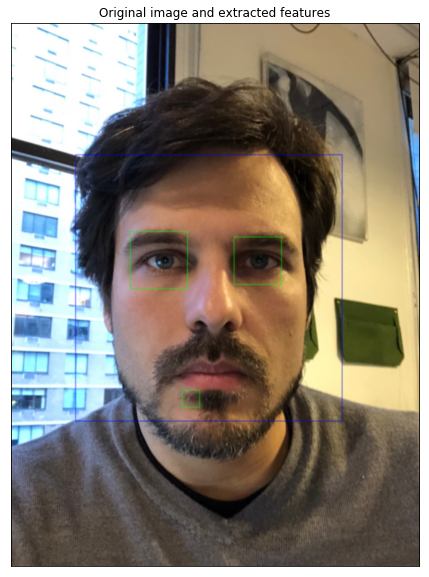

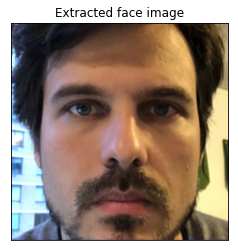

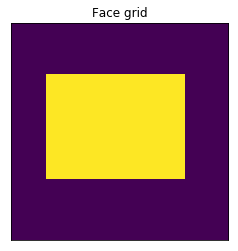

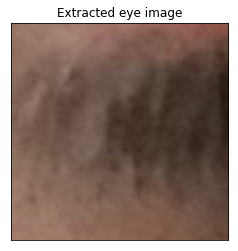

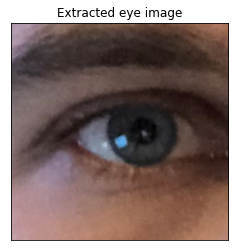

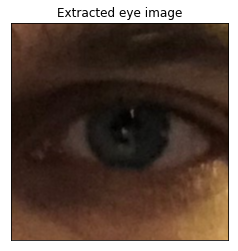

In [39]:
img, faces, face_features = extract_image_features('photos/IMG-1053.JPG')  
show_extraction_results(img, faces, face_features)

# Feeding the Input through the Network

Here we will load the model from https://github.com/CSAILVision/GazeCapture.  We will use the 25x snapshot which is trained to handle variations in the images.

In [40]:
import sys
sys.path.append('/usr/bin/caffe')
import caffe

In [41]:
caffe.set_mode_cpu()

model_root = "../GazeCapture/models/"

model_def = model_root + 'itracker_deploy.prototxt'
model_weights = model_root + 'snapshots/itracker25x_iter_92000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [ ]:
# run this if cuda enable and gpu has enough memory
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()

In [54]:
# set the batch size to 1
def set_batch_size(batch_size):
    net.blobs['image_left'].reshape(batch_size, 3, 224, 224)
    net.blobs['image_right'].reshape(batch_size, 3, 224, 224)
    net.blobs['image_face'].reshape(batch_size, 3, 224, 224)
    net.blobs['facegrid'].reshape(batch_size, 625, 1, 1)   
    
set_batch_size(1)

In [53]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.items():
    print(layer_name + '\t' + str(blob.data.shape))

image_left	(1, 3, 224, 224)
image_right	(1, 3, 224, 224)
image_face	(1, 3, 224, 224)
facegrid	(1, 625, 1, 1)
conv1	(256, 96, 54, 54)
pool1	(256, 96, 27, 27)
norm1	(256, 96, 27, 27)
conv2	(256, 256, 27, 27)
pool2	(256, 256, 13, 13)
norm2	(256, 256, 13, 13)
conv3	(256, 384, 13, 13)
conv4_l	(256, 64, 13, 13)
conv1_r	(256, 96, 54, 54)
pool1_r	(256, 96, 27, 27)
norm1_r	(256, 96, 27, 27)
conv2_r	(256, 256, 27, 27)
pool2_r	(256, 256, 13, 13)
norm2_r	(256, 256, 13, 13)
conv3_r	(256, 384, 13, 13)
conv4_r	(256, 64, 13, 13)
conv1_f	(256, 96, 54, 54)
pool1_f	(256, 96, 27, 27)
norm1_f	(256, 96, 27, 27)
conv2_f	(256, 256, 27, 27)
pool2_f	(256, 256, 13, 13)
norm2_f	(256, 256, 13, 13)
conv3_f	(256, 384, 13, 13)
conv4_f	(256, 64, 13, 13)
fc1_f	(256, 128)
fc2_f	(256, 64)
concat1	(256, 128, 13, 13)
fc1	(256, 128)
flatten	(256, 625)
fg_fc1	(256, 256)
fg_fc2	(256, 128)
concat2	(256, 320)
fc2	(256, 128)
fc3	(256, 2)


In [55]:
# load the mean images
import scipy.io

def get_mean_image(file_name):
    image_mean = np.array(scipy.io.loadmat(model_root + 'mean_images/' + file_name)['image_mean'])
    image_mean = image_mean.reshape(3, 224, 224)
    
    return image_mean.mean(1).mean(1)

mu_face = get_mean_image('mean_face_224.mat')
mu_left_eye = get_mean_image('mean_left_224.mat')
mu_right_eye = get_mean_image('mean_left_224.mat')

In [56]:
# create transformer for the input called 'data'
def create_image_transformer(layer_name, mean_image=None):  
    transformer = caffe.io.Transformer({layer_name: net.blobs[layer_name].data.shape})

    transformer.set_transpose(layer_name, (2,0,1))  # move image channels to outermost dimension
    if mean_image is not None:
        transformer.set_mean(layer_name, mean_image)            # subtract the dataset-mean value in each channel
    return transformer

left_eye_transformer = create_image_transformer('image_left', mu_left_eye)
right_eye_transformer = create_image_transformer('image_right', mu_right_eye)
face_transformer = create_image_transformer('image_face', mu_face)

# face grid transformer just passes through the data
face_grid_transformer = caffe.io.Transformer({'facegrid': net.blobs['facegrid'].data.shape})

In [62]:
import sys
def test_face(face, face_feature):
    face_image, eye_images, face_grid = face_feature
    
    if len(eye_images) < 2:
        return None
    
    start_ms = current_time()
    transformed_left_eye = left_eye_transformer.preprocess('image_left', eye_images[0])
    transformed_right_eye = right_eye_transformer.preprocess('image_right', eye_images[1])
    transformed_face = face_transformer.preprocess('image_face', face_image)
    transformed_face_grid = np.copy(face_grid).reshape(1, 625, 1, 1)
    
    net.blobs['image_left'].data[...] = transformed_left_eye
    net.blobs['image_right'].data[...] = transformed_right_eye
    net.blobs['image_face'].data[...] = transformed_face
    net.blobs['facegrid'].data[...] = transformed_face_grid
    
    output = net.forward()
    net.forward()
    print("Feeding through the network took " + str((current_time() - start_ms) * 1. / 1000) + "s")
    
    return np.copy(output['fc3'][0])
    

def test_faces(faces, face_features):
    outputs = []
    for i, face in enumerate(faces): 
        output = test_face(face, face_features[i])
        
        if output is not None:
            outputs.append(output)
            
    return outputs

In [64]:
outputs = test_faces(faces, face_features)
print("The outputs:", outputs)

Feeding through the network took 2.156s
The outputs: [array([-3.23428679,  2.01625013], dtype=float32)]


In [66]:
# units in cm
screen_w = 5.58
screen_h = 10.45
screen_aspect = screen_w / screen_h
camera_l = 2.299
camera_t = 0.91
screen_t = 1.719
screen_l = 0.438
phone_w = 6.727
phone_h = 13.844
screen_from_camera = [screen_t - camera_t, screen_l - camera_l]

camera_coords_percentage = [camera_t / phone_h, camera_l / phone_w]

#iphone 8 screen w and screen height from https://www.paintcodeapp.com/news/ultimate-guide-to-iphone-resolutions
screenW = 375
screenH = 667

phone_w_to_screen = phone_w / screen_w
phone_h_to_screen = phone_h / screen_h

In [72]:
def render_gaze(full_image, camera_center, cm_to_px, output):
    xScreen = output[0]
    yScreen = output[1]
    pixelGaze = [round(camera_center[0] - yScreen * cm_to_px), round(camera_center[1] + xScreen * cm_to_px)]
    
    cv2.circle(full_image,(int(pixelGaze[1]), int(pixelGaze[0])), 30, (0, 0, 255), -1)

    
def render_gazes(img, outputs):
    full_image = np.ones((round(img.shape[0] * 2), round(img.shape[1] * 2), 3), dtype=np.uint8)

    full_image_center = [round(full_image.shape[0] * 0.2), round(full_image.shape[1] *.5)]
    camera_center = full_image_center

    cm_to_px = img.shape[0] * 1. / screen_h

    screen_from_camera_px = [round(screen_from_camera[0] * cm_to_px), round(screen_from_camera[1] * cm_to_px)]

    screen_start = [camera_center[0] + screen_from_camera_px[0], camera_center[1] + screen_from_camera_px[1]]
    
    full_image[screen_start[0]:screen_start[0] + img.shape[0], screen_start[1]:screen_start[1] + img.shape[1], :] = img[:, :, :]

    cv2.circle(full_image,(camera_center[1],camera_center[0]), 30, (255, 0, 0), -1)
    
    for output in outputs:
        render_gaze(full_image, camera_center, cm_to_px, output)

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")    

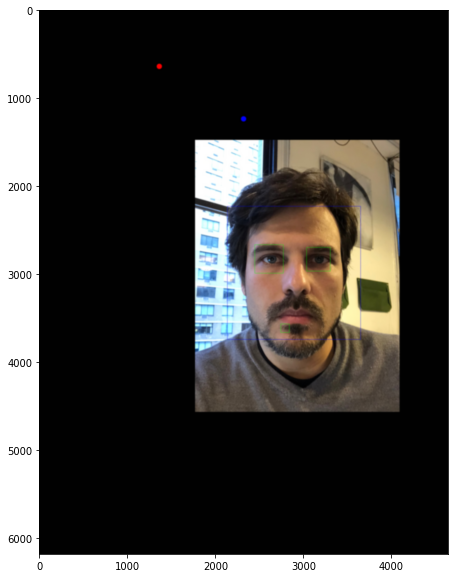

In [73]:
render_gazes(img, outputs)t

In [74]:
# lets create a reusable function to extract the features, pass through the network, and render output
def test_and_render(image_path, show_details=False):
    img, faces, face_features = extract_image_features(image_path)
    outputs = test_faces(faces, face_features)

    if show_details:        
        show_extraction_results(img, faces, face_features)

    render_gazes(img, outputs)

Face and eye extraction took:  0.493s
Feeding through the network took 2.261s
Feeding through the network took 2.249s


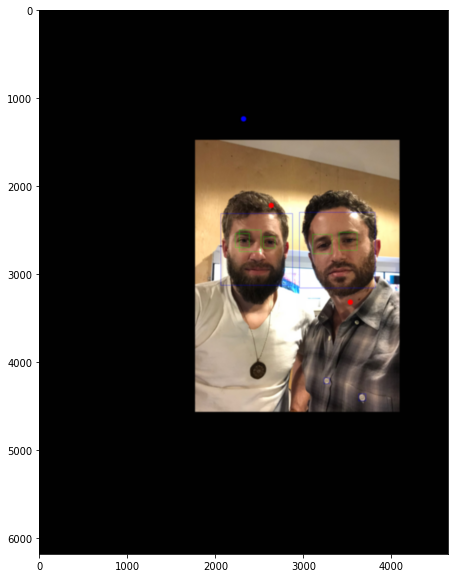

In [75]:
test_and_render('photos/IMG-1066.JPG')

Face and eye extraction took:  0.729s
Feeding through the network took 2.22s


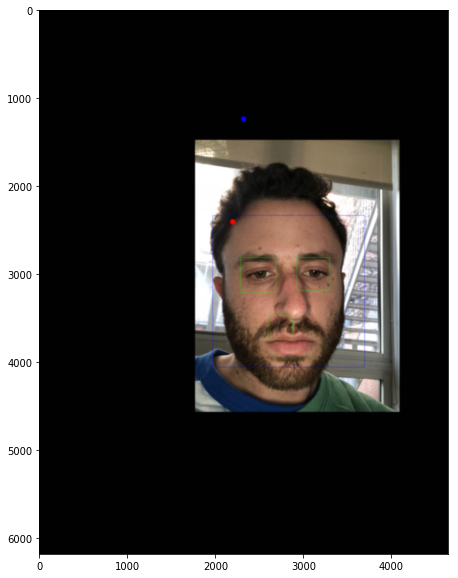

In [85]:
test_and_render('photos/IMG-1036.JPG')

Face and eye extraction took:  0.506s
Feeding through the network took 2.107s


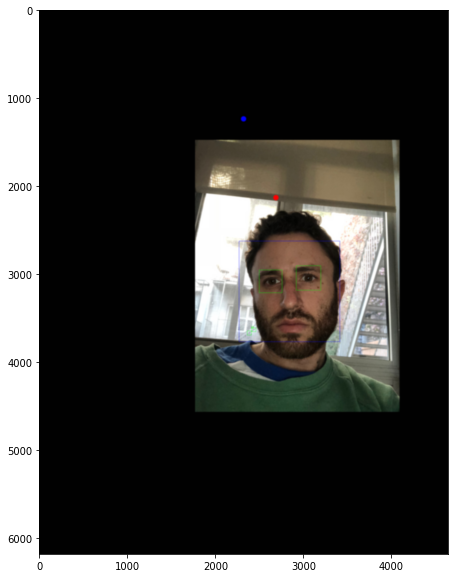

In [90]:
test_and_render('photos/IMG-1037.JPG')

Face and eye extraction took:  0.555s
Feeding through the network took 2.517s


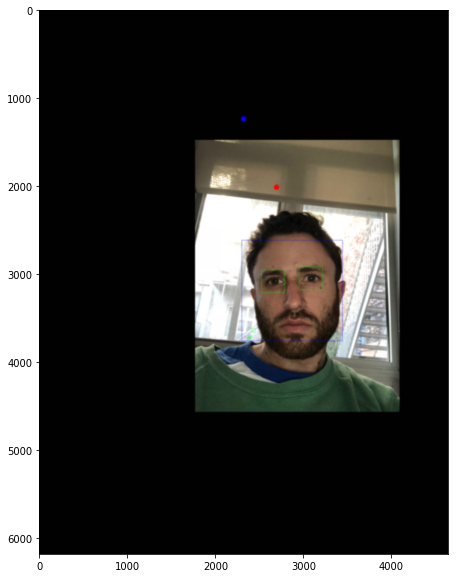

In [91]:
test_and_render('photos/IMG-1038.JPG')

Face and eye extraction took:  0.667s
Feeding through the network took 2.279s


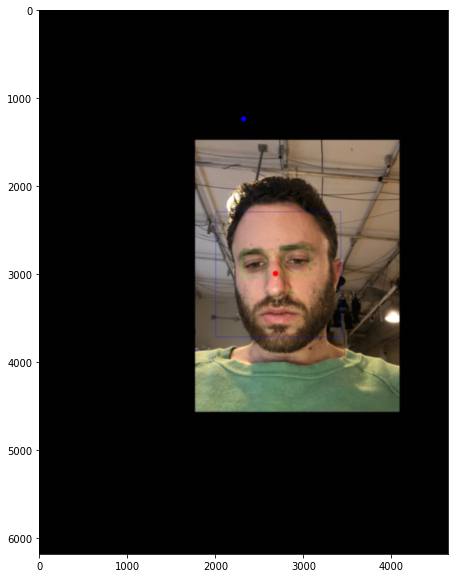

In [92]:
test_and_render('photos/IMG-1044.JPG')

Face and eye extraction took:  0.736s
Feeding through the network took 2.168s


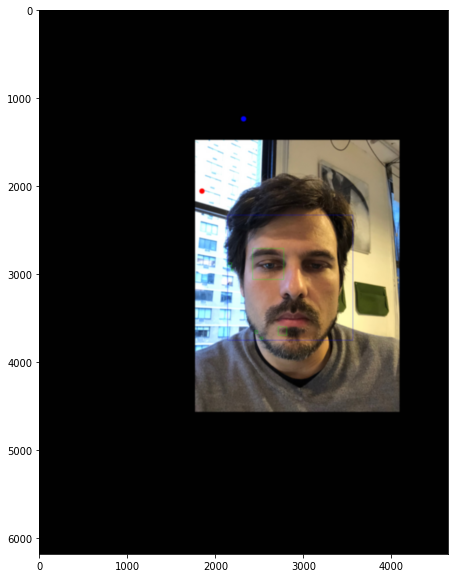

In [80]:
test_and_render('photos/IMG-1052.JPG')

Face and eye extraction took:  0.703s
Feeding through the network took 2.165s


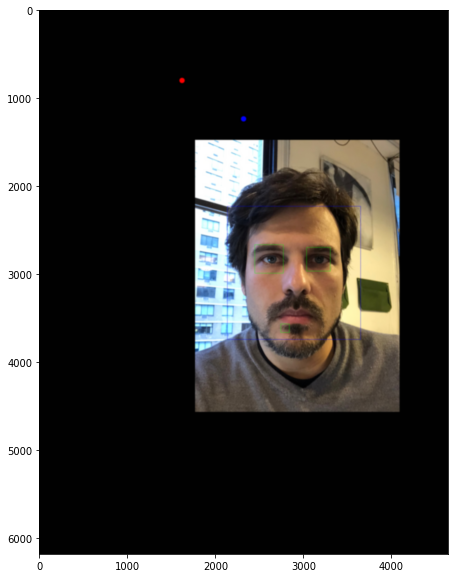

In [93]:
test_and_render('photos/IMG-1053.JPG')

Face and eye extraction took:  0.889s
Feeding through the network took 2.115s


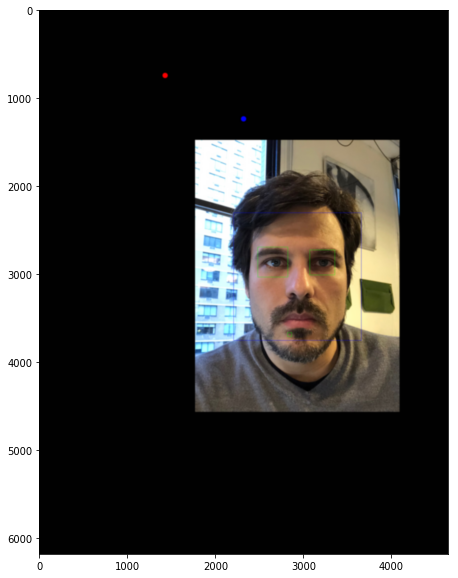

In [94]:
test_and_render('photos/IMG-1054.JPG')

Face and eye extraction took:  0.649s
Feeding through the network took 2.16s


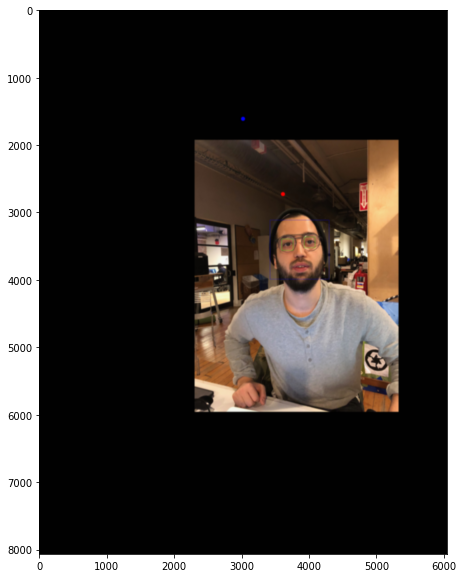

In [83]:
test_and_render('photos/IMG-1055.JPG')

# TODO:
* Subtract mean image
* Connect to camera feed.
* Try to reduce opencv face detection time

In [99]:
cap.release()

In [140]:
PORTRAIT = 1
PORTRAIT_UPSIDE_DOWN = 2 #(iPad only)
LANDSCAPE_R = 3 #with home button on the right
LANDSCAPE_L = 4 #with home button on the left

# % screen2cam.m
# %
# % Convert screen coordinates (in points, or centimeters if useCm is true)
# % to physical coordinates (in centimeters) from the camera (our prediction
# % space). The device data is pulled from apple_device_data.csv via
# % loadAppleDeviceData.m. cam2screen.m is the inverse.
# %
# % Input Parameters
# % ================
# % With the exception of useCm (which is a logical scalar), all input
# % vectors should be the same size, with an element for each sample to be
# % processed.
# % - xScreen/yScreen: Screen coordinates from the top-left corner of the
# %     screen. Positive x is down and positive y is right. Units are
# %     determined by useCm.
# % - orientation: The orientation of the device as an integer (1-4). See the
# %     README for more information.
# % - device: Cell array of strings describing the device name.
# % - screenW/screenH: Size of the active screen area. This allows us to
# %     account for Display Zoom. This assumes the active screen area covers
# %     the entire screen (which is the case in GazeCapture).
# % - useCm: Whether to interpret xScreen/yScreen as points or centimeters.
# %     Default: points.
# %
# % Output Parameters
# % =================
# % - xCam/yCam: xScreen/yScreen transformed to our prediciton space,
# %     measured in centimeters from the center of the camera on the device,
# %     dependent on the orientation of the device.
def screen2cam(xScreen, yScreen, orientation, device, screenW, screenH, useCm):

#     if nargin < 7:
#         useCm = false

    device_data = get_apple_device_data(device)

#     processed = false(size(xScreen))
#     xCam = NaN(size(xScreen))
#     yCam = NaN(size(yScreen))

    #% Process device by device.
    # for i = 1:length(deviceName)
    #   curr = strcmpi(device, deviceName(i))
    #   #xCurr = xScreen(curr)
    #   #yCurr = yScreen(curr)
    #   #oCurr = orientation(curr)
    IS_PORTRAIT = orientation == PORTRAIT
    IS_PORTRAIT_UPSIDE_DOWN = orientation == PORTRAIT_UPSIDE_DOWN
    IS_LANDSCAPE_R = orientation == LANDSCAPE_R
    IS_LANDSCAPE_L = orientation == LANDSCAPE_L
    # if ~useCm:
    #     screenWCurr = screenW(curr)
    #     screenHCurr = screenH(curr)

    print(device_data)
    dX = device_data['DeviceCameraToScreenXMm']
    dY = device_data['DeviceCameraToScreenYMm']
    dW = device_data['DeviceScreenWidthMm']
    dH = device_data['DeviceScreenHeightMm']

    xScreens = np.array(2)
    yScreens = np.array(2)

    if ~useCm:
        xScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] = xScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] * (dW / screenW[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)])
        yScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] = yScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] * (dH / screenH[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)])
        xScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] = xScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] * (dH / screenW[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)])
        yScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] = yScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] * (dW / screenH[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)])
    else:
        #% Convert cm to mm.
        xScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] = xScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] * 10
        yScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] = yScreens[logical_or(IS_PORTRAIT , IS_PORTRAIT_UPSIDE_DOWN)] * 10
        xScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] = xScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] * 10
        yScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] = yScreens[logical_or(IS_LANDSCAPE_R , IS_LANDSCAPE_L)] * 10


    #% Transform to camera space, depending on the orientation.
    xScreens[IS_PORTRAIT] = xScreens[IS_PORTRAIT] - dX
    yScreens[IS_PORTRAIT] = -dY - yScreens[IS_PORTRAIT]
    xScreens[IS_PORTRAIT_UPSIDE_DOWN] = dX - dW + xScreens[IS_PORTRAIT_UPSIDE_DOWN]
    yScreens[IS_PORTRAIT_UPSIDE_DOWN] = dY + dH - yScreens[IS_PORTRAIT_UPSIDE_DOWN]
    xScreens[IS_LANDSCAPE_R] = dY + xScreens[IS_LANDSCAPE_R]
    yScreens[IS_LANDSCAPE_R] = dW - dX - yScreens[IS_LANDSCAPE_R]
    xScreens[IS_LANDSCAPE_L] = -dY - dH + xScreens[IS_LANDSCAPE_L]
    yScreens[IS_LANDSCAPE_L] = dX - yScreens[IS_LANDSCAPE_L]

    #% Store the results.
    # xCam(curr) = xScreen
    # yCam(curr) = yScreen

    # processed = processed | curr

    #% Finally, convert mm to cm.
    return xScreens / 10, yScreens / 10


In [15]:
import csv

def load_apple_device_data():
    rows = []
    with open('../GazeCapture/code/apple_device_data.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        headers = next(reader)
        for line in reader:
            row = {}
            for header, column_value in zip(headers, line):
                 row[header] = np.NAN if column_value == 'NaN' else column_value
            rows.append(row)
         
#     print(rows)
    return rows        

def get_apple_device_data(device):
    for device_row in load_apple_device_data():
#         print(device_row)
        if (device_row['DeviceName'] == device):
            return device_row

In [65]:
def get_model_size():
    total_size = 0
    for layer_name, blob in net.blobs.items():
        total_size += sys.getsizeof(blob.data)
        print(layer_name + '\t' + str(sys.getsizeof(blob.data) / 1000))
    return total_size

print('total size:', str(get_model_size() / 1000))

image_left	0.144
image_right	0.144
image_face	0.144
facegrid	0.144
conv1	0.144
pool1	0.144
norm1	0.144
conv2	0.144
pool2	0.144
norm2	0.144
conv3	0.144
conv4_l	0.144
conv1_r	0.144
pool1_r	0.144
norm1_r	0.144
conv2_r	0.144
pool2_r	0.144
norm2_r	0.144
conv3_r	0.144
conv4_r	0.144
conv1_f	0.144
pool1_f	0.144
norm1_f	0.144
conv2_f	0.144
pool2_f	0.144
norm2_f	0.144
conv3_f	0.144
conv4_f	0.144
fc1_f	0.112
fc2_f	0.112
concat1	0.144
fc1	0.112
flatten	0.112
fg_fc1	0.112
fg_fc2	0.112
concat2	0.112
fc2	0.112
fc3	0.112
total size: 5.184


In [98]:
import cv2

cap = cv2.VideoCapture(0)


ret, frame = cap.read()

if ret:
    print('captureD frame')
    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), interpolation="bicubic")
else:
    print('failed to capture frame')

cap.release()



failed to capture frame
